# Predict the energy consumption of buildings

Using the 2016 Building energy benchmarking of Seattle (https://data.seattle.gov/dataset/2016-Building-Energy-Benchmarking/2bpz-gwpy) dataset (File : https://s3.eu-west-1.amazonaws.com/course.oc-static.com/projects/Data_Scientist_P4/2016_Building_Energy_Benchmarking.csv), we try here to model the energy consumption and greenhouse gases emition for future bulding from their surface, use and location. We will also evaluate if the energystar score, which is dificult to obtain, is a relevant metric that can help us build the model.

## Data cleaning

Here we clean the raw data, normalize the numerical ones and encode the categorical ones. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler


pd.set_option("display.max_rows" , 500)
pd.set_option("display.max_columns" , 500)
rawdf = pd.read_csv(r'E:\DL\2016_Building_Energy_Benchmarking.csv', encoding = 'utf8',sep=',',low_memory=False) #load csv file
print("Dataset has ",rawdf.shape[0]," individuals and ",rawdf.shape[1]," variables.")


Dataset has  3376  individuals and  46  variables.


In [2]:
rawdf

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,0659000030,7,DOWNTOWN,47.61220,-122.33799,1927,1.0,12,88434,0,88434,Hotel,Hotel,88434.0,NaN,NaN,NaN,NaN,NaN,60.0,81.699997,84.300003,182.500000,189.000000,7.226362e+06,7.456910e+06,2003882.00,1.156514e+06,3.946027e+06,12764.529300,1.276453e+06,False,NaN,Compliant,NaN,249.98,2.83
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.0,0659000220,7,DOWNTOWN,47.61317,-122.33393,1996,1.0,11,103566,15064,88502,"Hotel, Parking, Restaurant",Hotel,83880.0,Parking,15064.0,Restaurant,4622.0,NaN,61.0,94.800003,97.900002,176.100006,179.399994,8.387933e+06,8.664479e+06,0.00,9.504252e+05,3.242851e+06,51450.816410,5.145082e+06,False,NaN,Compliant,NaN,295.86,2.86
2,3,2016,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,Seattle,WA,98101.0,0659000475,7,DOWNTOWN,47.61393,-122.33810,1969,1.0,41,956110,196718,759392,Hotel,Hotel,756493.0,NaN,NaN,NaN,NaN,NaN,43.0,96.000000,97.699997,241.899994,244.100006,7.258702e+07,7.393711e+07,21566554.00,1.451544e+07,4.952666e+07,14938.000000,1.493800e+06,False,NaN,Compliant,NaN,2089.28,2.19
3,5,2016,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,Seattle,WA,98101.0,0659000640,7,DOWNTOWN,47.61412,-122.33664,1926,1.0,10,61320,0,61320,Hotel,Hotel,61320.0,NaN,NaN,NaN,NaN,NaN,56.0,110.800003,113.300003,216.199997,224.000000,6.794584e+06,6.946800e+06,2214446.25,8.115253e+05,2.768924e+06,18112.130860,1.811213e+06,False,NaN,Compliant,NaN,286.43,4.67
4,8,2016,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,Seattle,WA,98121.0,0659000970,7,DOWNTOWN,47.61375,-122.34047,1980,1.0,18,175580,62000,113580,"Hotel, Parking, Swimming Pool",Hotel,123445.0,Parking,68009.0,Swimming Pool,0.0,NaN,75.0,114.800003,118.699997,211.399994,215.600006,1.417261e+07,1.465650e+07,0.00,1.573449e+06,5.368607e+06,88039.984380,8.803998e+06,False,NaN,Compliant,NaN,505.01,2.88
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3371,50222,2016,Nonresidential COS,Office,Horticulture building,1600 S Dakota St,Seattle,WA,NaN,1624049080,2,GREATER DUWAMISH,47.56722,-122.31154,1990,1.0,1,12294,0,12294,Office,Office,12294.0,NaN,NaN,NaN,NaN,NaN,46.0,69.099998,76.699997,161.699997,176.100006,8.497457e+05,9.430032e+05,0.00,1.536550e+05,5.242709e+05,3254.750244,3.254750e+05,True,NaN,Error - Correct Default Data,NaN,20.94,1.70
3372,50223,2016,Nonresidential COS,Other,International district/Chinatown CC,719 8th Ave S,Seattle,WA,NaN,3558300000,2,DOWNTOWN,47.59625,-122.32283,2004,1.0,1,16000,0,16000,Other - Recreation,Other - Recreation,16000.0,NaN,NaN,NaN,NaN,NaN,NaN,59.400002,65.900002,114.199997,118.900002,9.502762e+05,1.053706e+06,0.00,1.162210e+05,3.965461e+05,5537.299805,5.537300e+05,False,NaN,Compliant,NaN,32.17,2.01
3373,50224,2016,Nonresidential COS,Other,Queen Anne Pool,1920 1st Ave W,Seattle,WA,NaN,1794501150,7,MAGNOLIA / QUEEN ANNE,47.63644,-122.35784,1974,1.0,1,13157,0,13157,"Fitness Center/Health Club/Gym, Other - Recrea...",Other - Recreation,7583.0,Fitness Center/Health Club/Gym,5574.0,Swimmin

The target features for our futur model (what we are trying to predict) are SiteEnergyUseWN(kBtu) and TotalGHGEmissions.
Checking for null values:

In [3]:
rawdf.isnull().sum()


OSEBuildingID                         0
DataYear                              0
BuildingType                          0
PrimaryPropertyType                   0
PropertyName                          0
Address                               0
City                                  0
State                                 0
ZipCode                              16
TaxParcelIdentificationNumber         0
CouncilDistrictCode                   0
Neighborhood                          0
Latitude                              0
Longitude                             0
YearBuilt                             0
NumberofBuildings                     8
NumberofFloors                        0
PropertyGFATotal                      0
PropertyGFAParking                    0
PropertyGFABuilding(s)                0
ListOfAllPropertyUseTypes             9
LargestPropertyUseType               20
LargestPropertyUseTypeGFA            20
SecondLargestPropertyUseType       1697
SecondLargestPropertyUseTypeGFA    1697


In [4]:
rawdf.describe()

,OSEBuildingID,DataYear,ZipCode,CouncilDistrictCode,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),Comments,TotalGHGEmissions,GHGEmissionsIntensity
count,3376.000000,3376.0,3360.000000,3376.000000,3376.000000,3376.000000,3376.000000,3368.000000,3376.000000,3.376000e+03,3376.000000,3.376000e+03,3.356000e+03,1679.000000,596.000000,2533.000000,3369.000000,3370.000000,3367.000000,3367.000000,3.371000e+03,3.370000e+03,3.367000e+03,3.367000e+03,3.367000e+03,3.367000e+03,3.367000e+03,0.0,3367.000000,3367.000000
mean,21208.991114,2016.0,98116.949107,4.439277,47.624033,-122.334795,1968.573164,1.106888,4.709123,9.483354e+04,8001.526066,8.683201e+04,7.917764e+04,28444.075817,11738.675166,67.918674,54.732116,57.033798,134.232848,137.783932,5.403667e+06,5.276726e+06,2.745959e+05,1.086639e+06,3.707612e+06,1.368505e+04,1.368505e+06,NaN,119.723971,1.175916
std,12223.757015,0.0,18.615205,2.120625,0.047758,0.027203,33.088156,2.108402,5.494465,2.188376e+05,32326.723928,2.079398e+05,2.017034e+05,54392.917928,29331.199286,26.873271,56.273124,57.163330,139.287554,139.109807,2.161063e+07,1.593879e+07,3.912173e+06,4.352478e+06,1.485066e+07,6.709781e+04,6.709781e+06,NaN,538.832227,1.821452
min,1.000000,2016.0,98006.000000,1.000000,47.499170,-122.414250,1900.000000,0.000000,0.000000,1.128500e+04,0.000000,3.636000e+03,5.656000e+03,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,-2.100000,0.000000e+00,0.000000e+00,0.000000e+00,-3.382680e+04,-1.154170e+05,0.000000e+00,0.000000e+00,NaN,-0.800000,-0.020000
25%,19990.750000,2016.0,98105.000000,3.000000,47.599860,-122.350662,1948.000000,1.000000,2.000000,2.848700e+04,0.000000,2.775600e+04,2.509475e+04,5000.000000,2239.000000,53.000000,27.900000,29.400000,74.699997,78.400002,9.251286e+05,9.701822e+05,0.000000e+00,1.874229e+05,6.394870e+05,0.000000e+00,0.000000e+00,NaN,9.495000,0.210000
50%,23112.000000,2016.0,98115.000000,4.000000,47.618675,-122.332495,1975.000000,1.000000,4.000000,4.417500e+04,0.000000,4.321600e+04,3.989400e+04,10664.000000,5043.000000,75.000000,38.599998,40.900002,96.199997,101.099998,1.803753e+06,1.904452e+06,0.000000e+00,3.451299e+05,1.177583e+06,3.237538e+03,3.237540e+05,NaN,33.920000,0.610000
75%,25994.250000,2016.0,98122.000000,7.000000,47.657115,-122.319407,1997.000000,1.000000,5.000000,9.099200e+04,0.000000,8.427625e+04,7.620025e+04,26640.000000,10138.750000,90.000000,60.400002,64.275002,143.899994,148.349998,4.222455e+06,4.381429e+06,0.000000e+00,8.293178e+05,2.829632e+06,1.189033e+04,1.189034e+06,NaN,93.940000,1.370000
max,50226.000000,2016.0,98272.000000,7.000000,47.733870,-122.220966,2015.000000,111.000000,99.000000,9.320156e+06,512608.000000,9.320156e+06,9.320156e+06,686750.000000,459748.000000,100.000000,834.400024,834.400024,2620.000000,2620.000000,8.739237e+08,4.716139e+08,1.349435e+08,1.925775e+08,6.570744e+08,2.979090e+06,2.979090e+08,NaN,16870.980000,34.090000


Checking for duplicate (we take "OSEBuildingID" as primary key), and deleting them. (NB their is none for this dataset)

In [5]:
rawdf.duplicated().sum()


0

In [6]:
rawdf.duplicated(subset="OSEBuildingID").sum()


0

In [7]:
rawdf = rawdf.drop_duplicates(subset=['OSEBuildingID']).reset_index(drop=True) #drop duplicates having the same 'OSEBuildingID' master key identifier

We are only interested by non residential buildings. We only keep "Nonresidential COS", "Nonresidential WA", "NonResidential" "Campus" and "SPS-District K-12" (schools) building types. We end up with 1668 entries.

[Text(0.5, 1.0, 'Building types')]

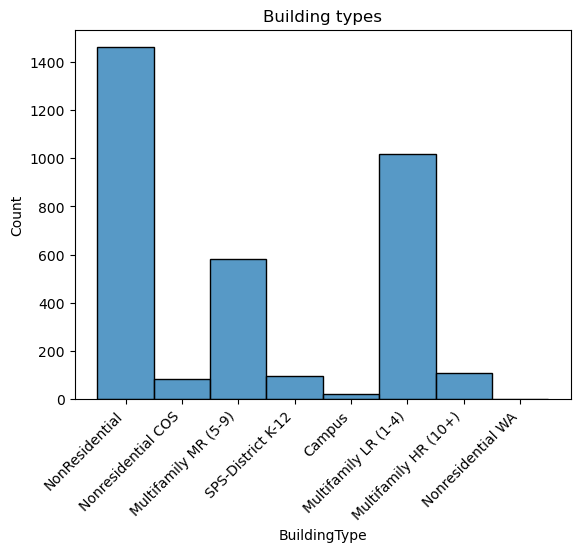

In [8]:
histplot = sns.histplot(data=rawdf["BuildingType"])
plt.xticks(rotation=45,horizontalalignment='right')
histplot.set(title='Building types')

In [9]:
#New dataset with only non residential entry
resdf = pd.DataFrame(rawdf.loc[
                    (rawdf["BuildingType"]== "Nonresidential COS") |
                    (rawdf["BuildingType"]== "Nonresidential WA") |
                    (rawdf["BuildingType"]== "NonResidential") |
                    (rawdf["BuildingType"]== "Campus") |
                    (rawdf["BuildingType"]== "SPS-District K-12")])
print("Dataset has ",resdf.shape[0]," individuals and ",resdf.shape[1]," variables.")

Dataset has  1668  individuals and  46  variables.


[Text(0.5, 1.0, 'Building types')]

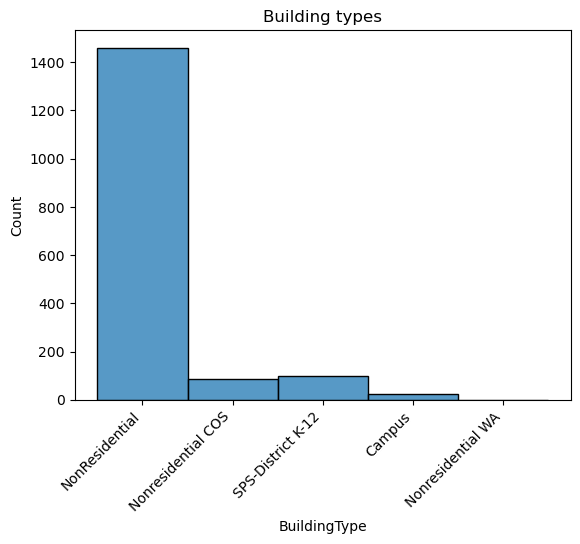

In [10]:
histplot = sns.histplot(data=resdf["BuildingType"])
plt.xticks(rotation=45,horizontalalignment='right')
histplot.set(title='Building types')

As the dataset already flag some outliers, we discard them (there is only 3)

In [11]:
#Setting outliers aside
resdf = resdf.loc[(resdf["Outlier"].isna())]
print("Dataset has ",resdf.shape[0]," individuals and ",resdf.shape[1]," variables.")

Dataset has  1651  individuals and  46  variables.


There is still some missing values in features we take interset in : 

In [12]:
resdf.isnull().sum()


OSEBuildingID                         0
DataYear                              0
BuildingType                          0
PrimaryPropertyType                   0
PropertyName                          0
Address                               0
City                                  0
State                                 0
ZipCode                              16
TaxParcelIdentificationNumber         0
CouncilDistrictCode                   0
Neighborhood                          0
Latitude                              0
Longitude                             0
YearBuilt                             0
NumberofBuildings                     2
NumberofFloors                        0
PropertyGFATotal                      0
PropertyGFAParking                    0
PropertyGFABuilding(s)                0
ListOfAllPropertyUseTypes             2
LargestPropertyUseType                6
LargestPropertyUseTypeGFA             6
SecondLargestPropertyUseType        803
SecondLargestPropertyUseTypeGFA     803


Looking at the location categorical data :

In [13]:
resdf['LargestPropertyUseType'].value_counts()

Office                                                  491
Non-Refrigerated Warehouse                              199
K-12 School                                             137
Retail Store                                             97
Other                                                    95
Hotel                                                    75
Worship Facility                                         69
Distribution Center                                      54
Supermarket/Grocery Store                                41
Medical Office                                           41
Other - Recreation                                       31
Parking                                                  30
Self-Storage Facility                                    27
College/University                                       24
Residence Hall/Dormitory                                 22
Other - Entertainment/Public Assembly                    21
Senior Care Community                   

In [14]:
resdf['SecondLargestPropertyUseType'].value_counts()

Parking                                                 333
Office                                                  167
Retail Store                                             85
Other                                                    44
Non-Refrigerated Warehouse                               29
Restaurant                                               29
Fitness Center/Health Club/Gym                           16
Multifamily Housing                                      12
Data Center                                              12
Other - Services                                         11
Supermarket/Grocery Store                                10
Laboratory                                                8
Medical Office                                            8
Bank Branch                                               7
Other - Entertainment/Public Assembly                     7
Distribution Center                                       7
K-12 School                             

In [15]:
resdf.groupby(['LargestPropertyUseType'])['GHGEmissionsIntensity'].mean().sort_values(ascending=False)

LargestPropertyUseType
Hospital (General Medical & Surgical)                   7.411000
Restaurant                                              7.316667
Laboratory                                              7.136923
Urgent Care/Clinic/Other Outpatient                     5.775000
Museum                                                  5.366000
Other - Restaurant/Bar                                  5.330000
Other - Recreation                                      5.113226
Supermarket/Grocery Store                               4.915366
Data Center                                             4.500000
Other/Specialty Hospital                                4.200000
Fitness Center/Health Club/Gym                          3.862000
Senior Care Community                                   3.650000
Other - Education                                       3.502500
Other - Mall                                            3.445000
Police Station                                          3.100000
Li

This seems to indicate a correlation between the property use and the emsision intensity we try to predict. Those categorical data will be encoded later. For now we isolate intersesting features to study them :

In [16]:
#creating subset of interest 
intcol = ["OSEBuildingID","YearBuilt","Neighborhood","LargestPropertyUseType","LargestPropertyUseTypeGFA","SecondLargestPropertyUseType","SecondLargestPropertyUseTypeGFA","ThirdLargestPropertyUseType","ThirdLargestPropertyUseTypeGFA","NumberofBuildings","NumberofFloors","PropertyGFATotal","PropertyGFAParking","PropertyGFABuilding(s)","SteamUse(kBtu)","Electricity(kBtu)","NaturalGas(kBtu)","ENERGYSTARScore","SiteEnergyUseWN(kBtu)","TotalGHGEmissions"]
df = pd.DataFrame(resdf[intcol])
print("Dataset has ",df.shape[0]," individuals and ",df.shape[1]," variables.")

Dataset has  1651  individuals and  20  variables.


In [17]:
df

,OSEBuildingID,YearBuilt,Neighborhood,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),ENERGYSTARScore,SiteEnergyUseWN(kBtu),TotalGHGEmissions
0,1,1927,DOWNTOWN,Hotel,88434.0,NaN,NaN,NaN,NaN,1.0,12,88434,0,88434,2003882.00,3.946027e+06,1.276453e+06,60.0,7.456910e+06,249.98
1,2,1996,DOWNTOWN,Hotel,83880.0,Parking,15064.0,Restaurant,4622.0,1.0,11,103566,15064,88502,0.00,3.242851e+06,5.145082e+06,61.0,8.664479e+06,295.86
2,3,1969,DOWNTOWN,Hotel,756493.0,NaN,NaN,NaN,NaN,1.0,41,956110,196718,759392,21566554.00,4.952666e+07,1.493800e+06,43.0,7.393711e+07,2089.28
3,5,1926,DOWNTOWN,Hotel,61320.0,NaN,NaN,NaN,NaN,1.0,10,61320,0,61320,2214446.25,2.768924e+06,1.811213e+06,56.0,6.946800e+06,286.43
4,8,1980,DOWNTOWN,Hotel,123445.0,Parking,68009.0,Swimming Pool,0.0,1.0,18,175580,62000,113580,0.00,5.368607e+06,8.803998e+06,75.0,1.465650e+07,505.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3371,50222,1990,GREATER DUWAMISH,Office,12294.0,NaN,NaN,NaN,NaN,1.0,1,12294,0,12294,0.00,5.242709e+05,3.254750e+05,46.0,9.430032e+05,20.94
3372,50223,2004,DOWNTOWN,Other - Recreation,16000.0,NaN,NaN,NaN,NaN,1.0,1,16000,0,16000,0.00,3.965461e+05,5.537300e+05,NaN,1.053706e+06,32.17
3373,50224,1974,MAGNOLIA / QUEEN ANNE,Other - Recreation,7583.0,Fitness Center/Health Club/Gym,5574.0,Swimming Pool,0.0,1.0,1,13157,0,13157,0.00,1.792159e+06,3.973739e+06,NaN,6.053764e+06,223.54
3374,50225,1989,GREATER DUWAMISH,Other - Recreation,6601.0,Fitness Center/Health Club/Gym,6501.0,Pre-school/Daycare,484.0,1.0,1,14101,0,14101,0.00,3.488702e+05,3.706010e+05,NaN,7.828413e+05,22.11


In [18]:
df.isnull().sum()

OSEBuildingID                         0
YearBuilt                             0
Neighborhood                          0
LargestPropertyUseType                6
LargestPropertyUseTypeGFA             6
SecondLargestPropertyUseType        803
SecondLargestPropertyUseTypeGFA     803
ThirdLargestPropertyUseType        1300
ThirdLargestPropertyUseTypeGFA     1300
NumberofBuildings                     2
NumberofFloors                        0
PropertyGFATotal                      0
PropertyGFAParking                    0
PropertyGFABuilding(s)                0
SteamUse(kBtu)                        2
Electricity(kBtu)                     2
NaturalGas(kBtu)                      2
ENERGYSTARScore                     568
SiteEnergyUseWN(kBtu)                 3
TotalGHGEmissions                     2
dtype: int64

Reformating our data and dropping 3 null values. (we spare ENERGYSTARScore null values as we will make two model : one with it and one without it, to assess its usefullness)

In [19]:
#Replacing null values for property use data (those data will be eraised later, this is only to preprocess them for one-hot encoding)
df['LargestPropertyUseTypeGFA'] = df['LargestPropertyUseTypeGFA'].fillna(0)
df['SecondLargestPropertyUseTypeGFA'] = df['SecondLargestPropertyUseTypeGFA'].fillna(0)
df['ThirdLargestPropertyUseTypeGFA'] = df['ThirdLargestPropertyUseTypeGFA'].fillna(0)
df['LargestPropertyUseType'] = df['LargestPropertyUseType'].fillna("UNKNOWN")
df['SecondLargestPropertyUseType'] = df['SecondLargestPropertyUseType'].fillna("UNKNOWN")
df['ThirdLargestPropertyUseType'] = df['ThirdLargestPropertyUseType'].fillna("UNKNOWN")

#setting string to capital letter
df['Neighborhood'] = df['Neighborhood'].str.upper()
df['LargestPropertyUseType'] = df['LargestPropertyUseType'].str.upper()
df['SecondLargestPropertyUseType'] = df['SecondLargestPropertyUseType'].str.upper()
df['ThirdLargestPropertyUseType'] = df['ThirdLargestPropertyUseType'].str.upper()

#encoding energy use (0 if the building doesnt use the energy type, 1 otherwise)
df["SteamUse(kBtu)"] = df["SteamUse(kBtu)"].fillna(0)
df["Electricity(kBtu)"] = df["Electricity(kBtu)"].fillna(0)
df["NaturalGas(kBtu)"] = df["NaturalGas(kBtu)"].fillna(0)
df.loc[df['SteamUse(kBtu)'] > 0, 'SteamUse(kBtu)'] = 1
df.loc[df['Electricity(kBtu)'] > 0, 'Electricity(kBtu)'] = 1
df.loc[df['NaturalGas(kBtu)'] > 0, 'NaturalGas(kBtu)'] = 1



#Doppping null values (spare ENERGYSTARScore)
df = df.dropna(subset=["OSEBuildingID","Neighborhood","LargestPropertyUseType","YearBuilt","NumberofBuildings","NumberofFloors","PropertyGFATotal","PropertyGFAParking","PropertyGFABuilding(s)","SiteEnergyUseWN(kBtu)","TotalGHGEmissions","SteamUse(kBtu)","Electricity(kBtu)","NaturalGas(kBtu)"], inplace=False)
df.isnull().sum()

OSEBuildingID                        0
YearBuilt                            0
Neighborhood                         0
LargestPropertyUseType               0
LargestPropertyUseTypeGFA            0
SecondLargestPropertyUseType         0
SecondLargestPropertyUseTypeGFA      0
ThirdLargestPropertyUseType          0
ThirdLargestPropertyUseTypeGFA       0
NumberofBuildings                    0
NumberofFloors                       0
PropertyGFATotal                     0
PropertyGFAParking                   0
PropertyGFABuilding(s)               0
SteamUse(kBtu)                       0
Electricity(kBtu)                    0
NaturalGas(kBtu)                     0
ENERGYSTARScore                    566
SiteEnergyUseWN(kBtu)                0
TotalGHGEmissions                    0
dtype: int64

In [20]:
print("Dataset has ",df.shape[0]," individuals and ",df.shape[1]," variables.")

Dataset has  1648  individuals and  20  variables.


We run a correlation test on all our numerical data. We see that the two features we meant to predict are highly correlated and that the number of building, number of floors, surface and largest use type surface are correlated to them. The age of building seem to only have a minor role. 

[Text(0.5, 1.0, "Pearson's correlation heatmap")]

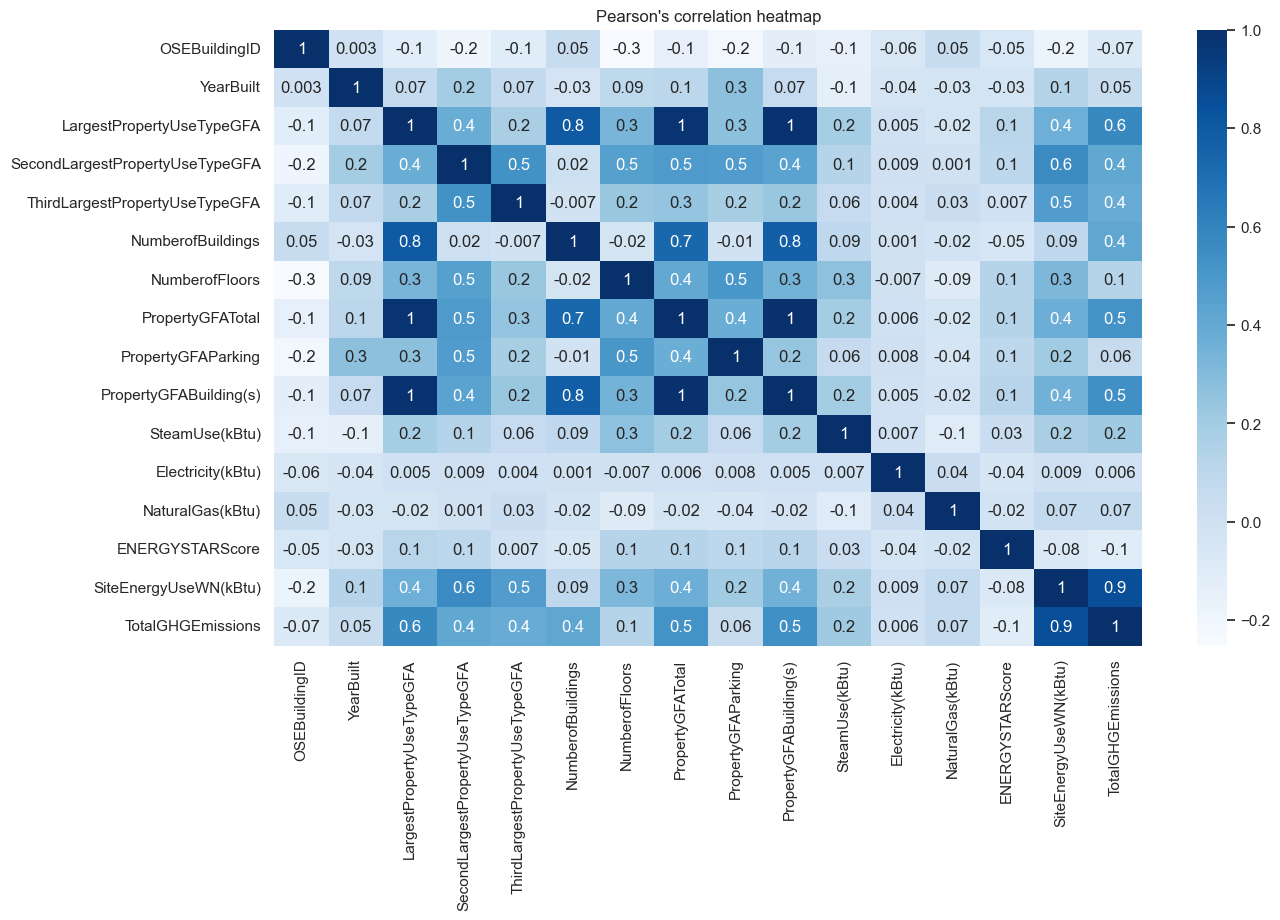

In [21]:
plt.figure(figsize=(14,8))
sns.set_theme(style="white")
corr = df.corr(method='pearson')
heatmap = sns.heatmap(corr, annot=True, cmap="Blues", fmt='.1g')
heatmap.set(title = "Pearson's correlation heatmap")

[Text(0.5, 1.0, "Spearman's correlation heatmap")]

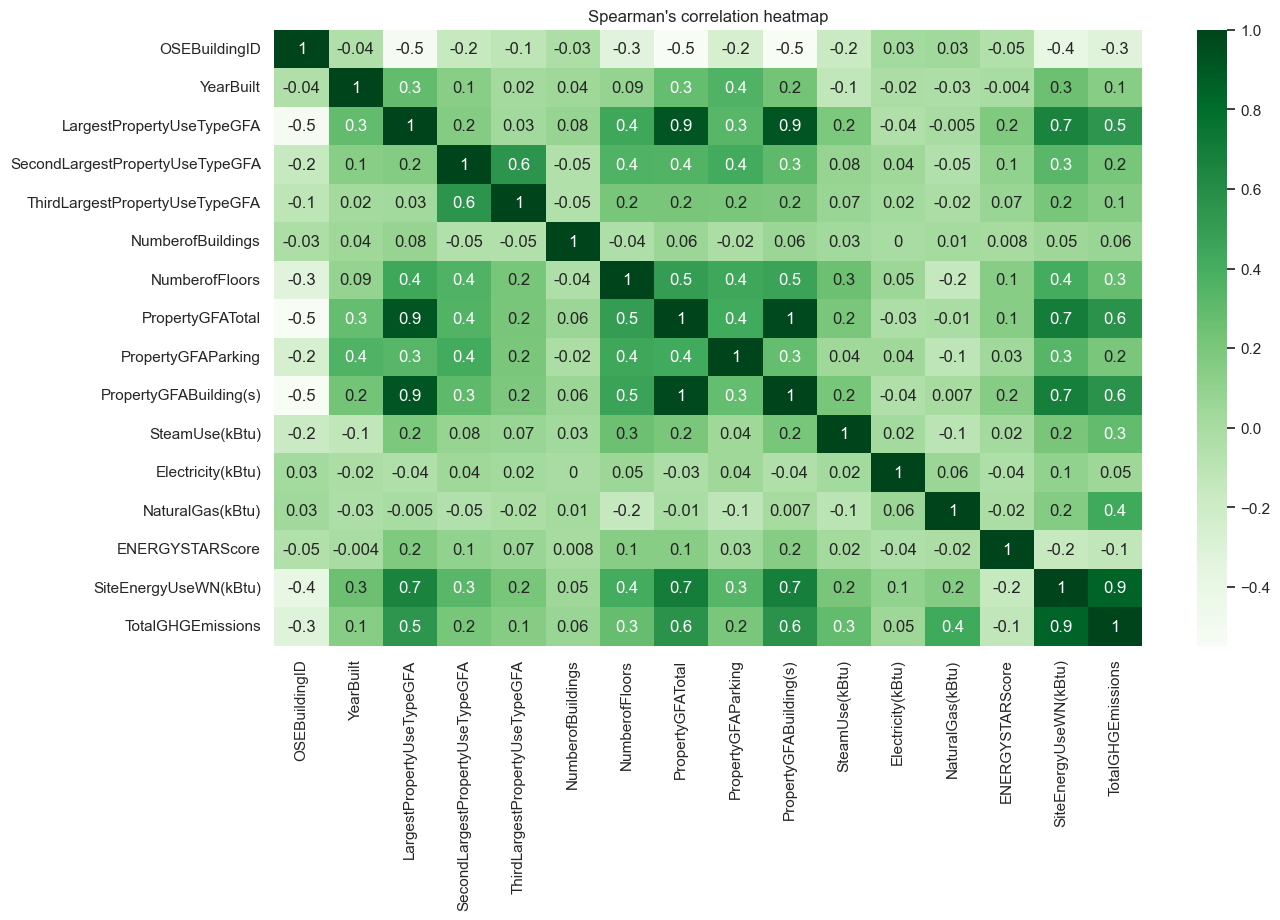

In [22]:
plt.figure(figsize=(14,8))
sns.set_theme(style="white")
corr = df.corr(method = 'spearman')
heatmap = sns.heatmap(corr, annot=True, cmap="Greens", fmt='.1g')
heatmap.set(title = "Spearman's correlation heatmap")

Here we evaluate each numerical features and drop absurd values, for example the negative number of floors, we drop around a 100 entries here. 

[Text(0.5, 1.0, 'PropertyGFAParking')]

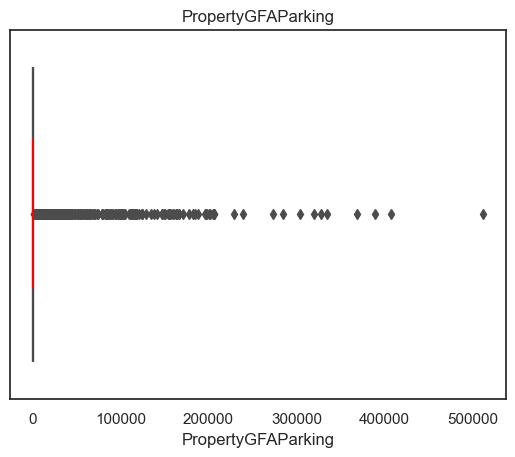

In [23]:
boxplot = sns.boxplot(data=df, x="PropertyGFAParking", notch=True, medianprops={"color": "red"})
boxplot.set(title='PropertyGFAParking')

In [24]:
#Dropping outliers
df = df[(df.PropertyGFAParking >= 0)]

print("Dataset has ",df.shape[0]," individuals and ",df.shape[1]," variables.")

Dataset has  1648  individuals and  20  variables.


[Text(0.5, 1.0, 'PropertyGFAParking')]

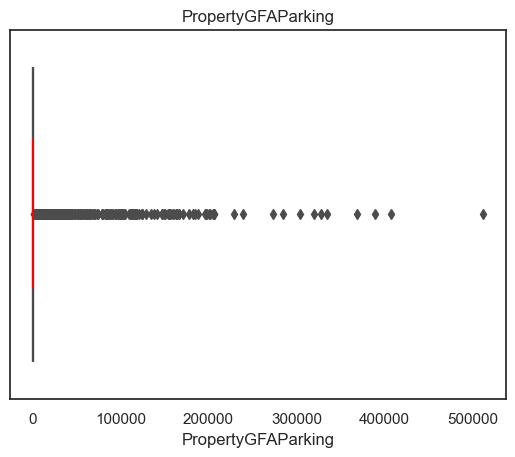

In [25]:
boxplot = sns.boxplot(data=df, x="PropertyGFAParking", notch=True, medianprops={"color": "red"})
boxplot.set(title='PropertyGFAParking')

[Text(0.5, 1.0, 'PropertyGFABuilding(s)')]

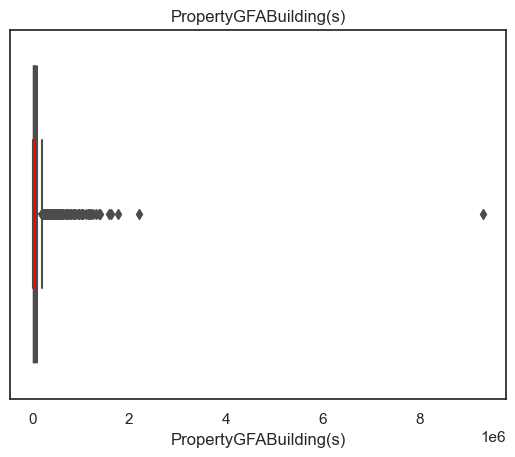

In [26]:
boxplot = sns.boxplot(data=df, x="PropertyGFABuilding(s)", notch=True, medianprops={"color": "red"})
boxplot.set(title='PropertyGFABuilding(s)')

In [27]:
#Dropping outliers
df = df[(df["PropertyGFABuilding(s)"] > 0)&(df["PropertyGFABuilding(s)"] < 2*1e6)]

print("Dataset has ",df.shape[0]," individuals and ",df.shape[1]," variables.")

Dataset has  1646  individuals and  20  variables.


[Text(0.5, 1.0, 'PropertyGFABuilding(s)')]

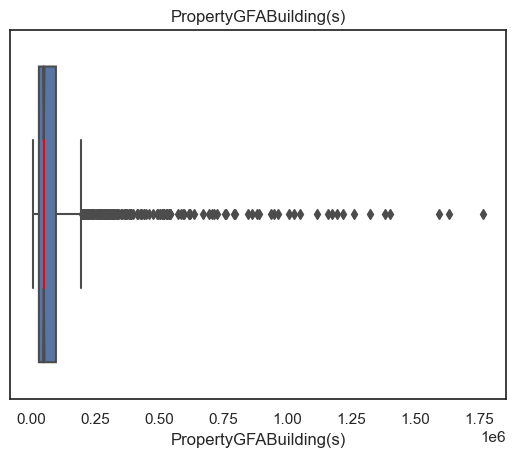

In [28]:
boxplot = sns.boxplot(data=df, x="PropertyGFABuilding(s)", notch=True, medianprops={"color": "red"})
boxplot.set(title='PropertyGFABuilding(s)')

[Text(0.5, 1.0, 'NumberofFloors')]

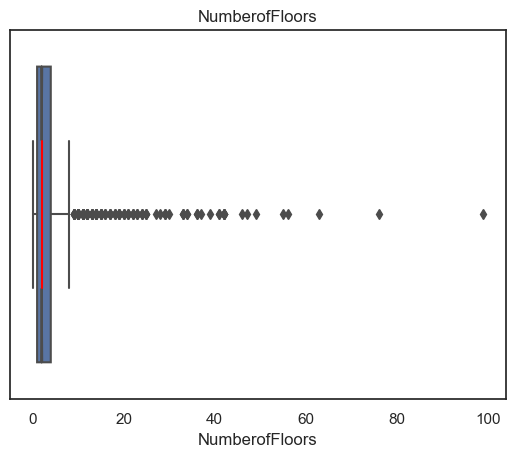

In [29]:
boxplot = sns.boxplot(data=df, x="NumberofFloors", notch=True, medianprops={"color": "red"})
boxplot.set(title='NumberofFloors')

In [30]:
#Dropping outliers
df = df[(df.NumberofFloors > 0)]

print("Dataset has ",df.shape[0]," individuals and ",df.shape[1]," variables.")

Dataset has  1631  individuals and  20  variables.


[Text(0.5, 1.0, 'NumberofFloors')]

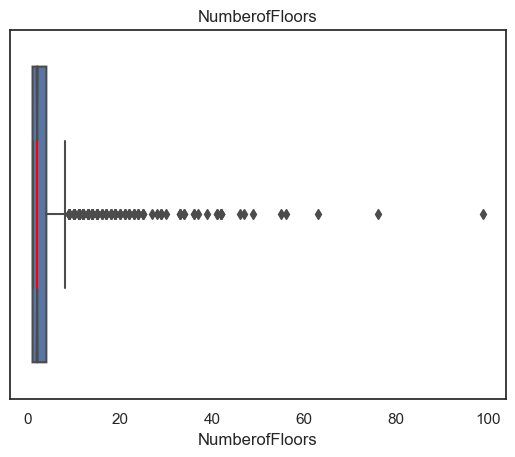

In [31]:
boxplot = sns.boxplot(data=df, x="NumberofFloors", notch=True, medianprops={"color": "red"})
boxplot.set(title='NumberofFloors')

[Text(0.5, 1.0, 'NumberofBuildings')]

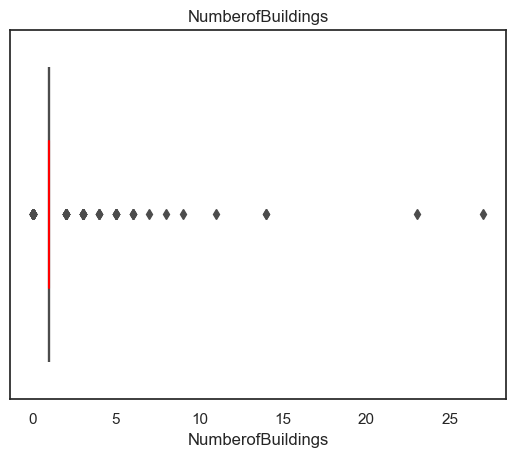

In [32]:
boxplot = sns.boxplot(data=df, x="NumberofBuildings", notch=True, medianprops={"color": "red"})
boxplot.set(title='NumberofBuildings')

In [33]:
#Dropping outliers
df = df[(df.NumberofBuildings > 0)&(df.NumberofBuildings < 20)]
print("Dataset has ",df.shape[0]," individuals and ",df.shape[1]," variables.")

Dataset has  1578  individuals and  20  variables.


[Text(0.5, 1.0, 'NumberofBuildings')]

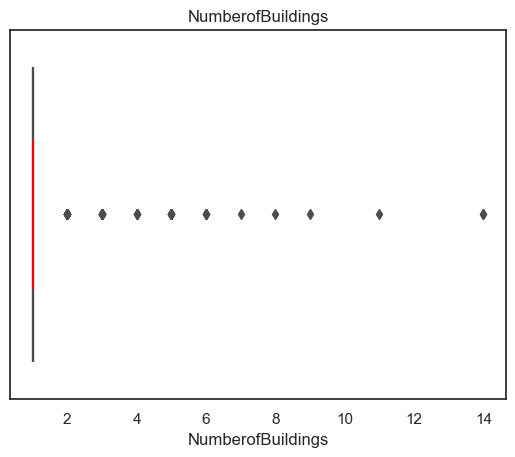

In [34]:
boxplot = sns.boxplot(data=df, x="NumberofBuildings", notch=True, medianprops={"color": "red"})
boxplot.set(title='NumberofBuildings')

[Text(0.5, 1.0, 'TotalGHGEmissions')]

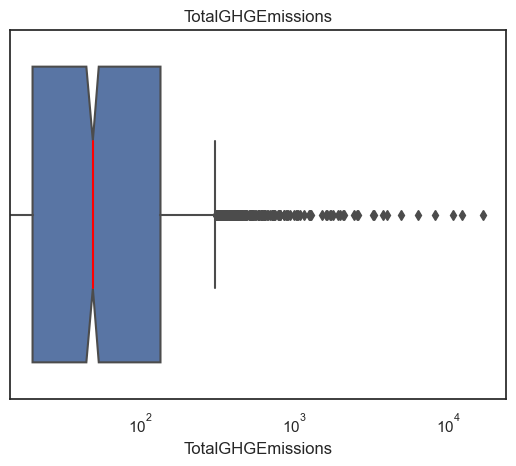

In [35]:
boxplot = sns.boxplot(data=df, x="TotalGHGEmissions", notch=True, medianprops={"color": "red"})
boxplot.set_xscale("log")
boxplot.set(title='TotalGHGEmissions')

In [36]:
#Dropping outliers
df = df[(df.TotalGHGEmissions > 0)]

print("Dataset has ",df.shape[0]," individuals and ",df.shape[1]," variables.")

Dataset has  1571  individuals and  20  variables.


[Text(0.5, 1.0, 'TotalGHGEmissions')]

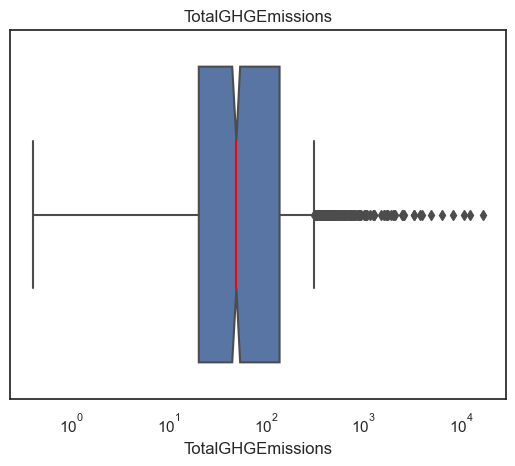

In [37]:
boxplot = sns.boxplot(data=df, x="TotalGHGEmissions", notch=True, medianprops={"color": "red"})
boxplot.set_xscale("log")
boxplot.set(title='TotalGHGEmissions')

[Text(0.5, 1.0, 'SiteEnergyUseWN(kBtu)')]

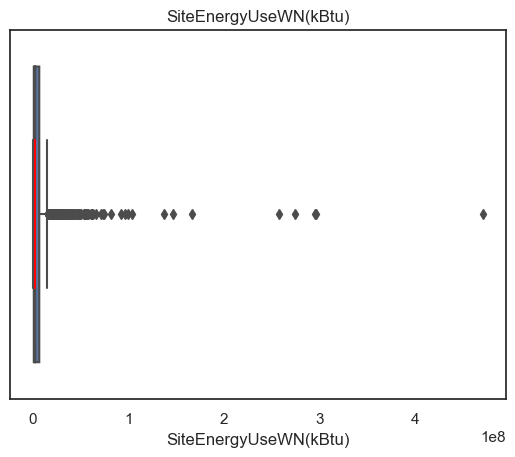

In [38]:
boxplot = sns.boxplot(data=df, x="SiteEnergyUseWN(kBtu)", notch=True, medianprops={"color": "red"})
boxplot.set(title='SiteEnergyUseWN(kBtu)')

In [39]:
#Dropping outliers
df = df[(df["SiteEnergyUseWN(kBtu)"] > 0)]

print("Dataset has ",df.shape[0]," individuals and ",df.shape[1]," variables.")

Dataset has  1552  individuals and  20  variables.


[Text(0.5, 1.0, 'SiteEnergyUseWN(kBtu)')]

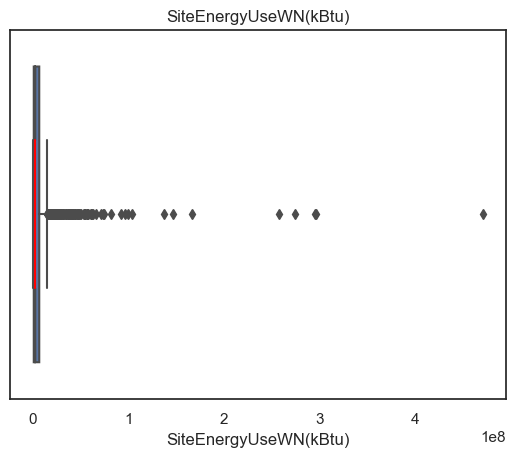

In [40]:
boxplot = sns.boxplot(data=df, x="SiteEnergyUseWN(kBtu)", notch=True, medianprops={"color": "red"})
boxplot.set(title='SiteEnergyUseWN(kBtu)')

[Text(0.5, 1.0, 'YearBuilt')]

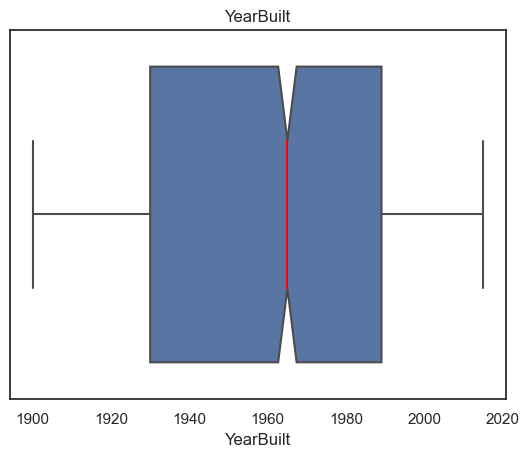

In [41]:
boxplot = sns.boxplot(data=df, x="YearBuilt", notch=True, medianprops={"color": "red"})
boxplot.set(title='YearBuilt')

[Text(0.5, 1.0, 'ENERGYSTARScore')]

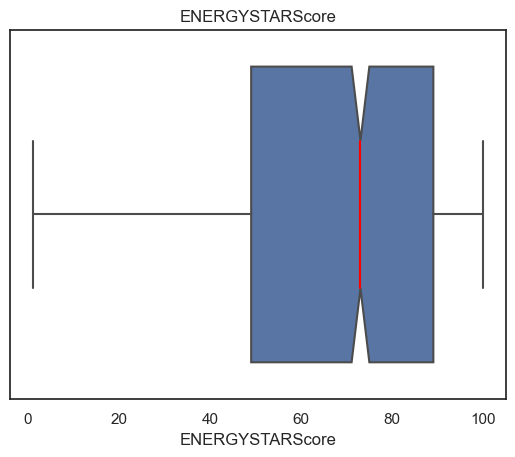

In [42]:
boxplot = sns.boxplot(data=df, x="ENERGYSTARScore", notch=True, medianprops={"color": "red"})
boxplot.set(title='ENERGYSTARScore')

Here we make the univariable study of each our numerical data. We confirm the results of our previous correlation map.

In [43]:
#Creating clean dataframe for plotting
dfclean = df.dropna()
dfclean.shape

(1040, 20)

[Text(0.5, 1.0, 'Emissions against YearBuilt')]

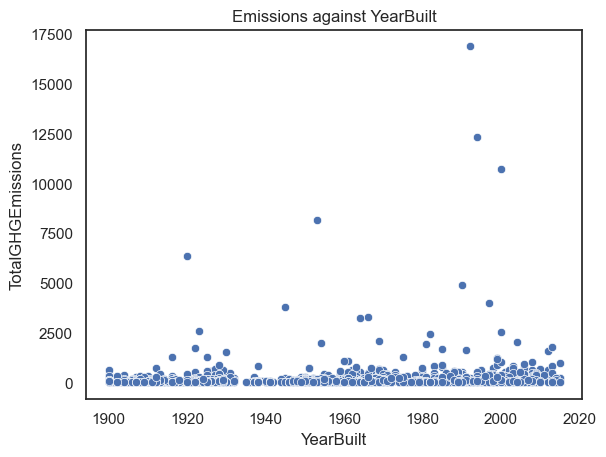

In [44]:
sns.scatterplot(data=df, x="YearBuilt", y="TotalGHGEmissions").set(title = "Emissions against YearBuilt")


[Text(0.5, 1.0, 'Emissions against PropertyGFABuilding(s)')]

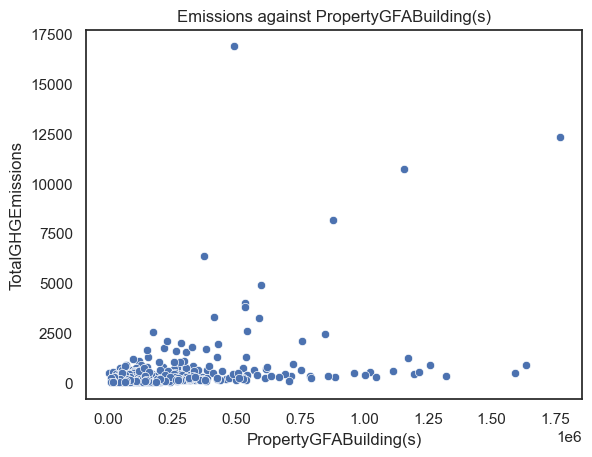

In [45]:
sns.scatterplot(data=df, x="PropertyGFABuilding(s)", y="TotalGHGEmissions").set(title = "Emissions against PropertyGFABuilding(s)")


[Text(0.5, 1.0, 'Emissions against PropertyGFAParking')]

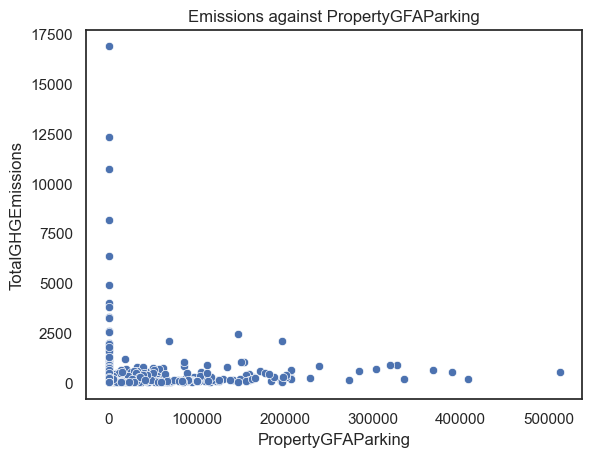

In [46]:
sns.scatterplot(data=df, x="PropertyGFAParking", y="TotalGHGEmissions").set(title = "Emissions against PropertyGFAParking")


[Text(0.5, 1.0, 'Emissions against SiteEnergyUseWN(kBtu)')]

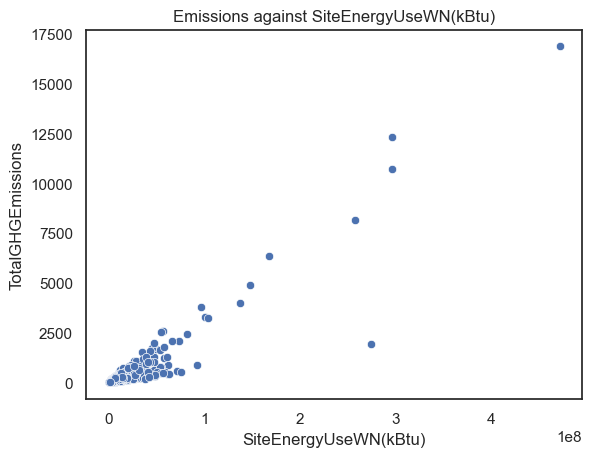

In [47]:
sns.scatterplot(data=df, x="SiteEnergyUseWN(kBtu)", y="TotalGHGEmissions").set(title = "Emissions against SiteEnergyUseWN(kBtu)")


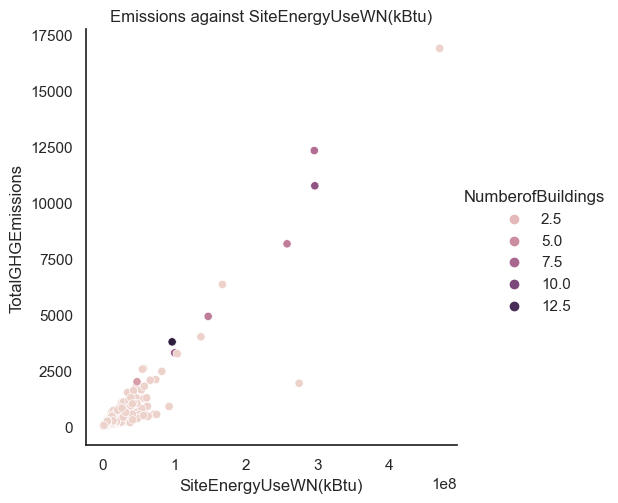

In [48]:
sns.relplot(data=df,x="SiteEnergyUseWN(kBtu)",y="TotalGHGEmissions",hue="NumberofBuildings").set(title = "Emissions against SiteEnergyUseWN(kBtu)")

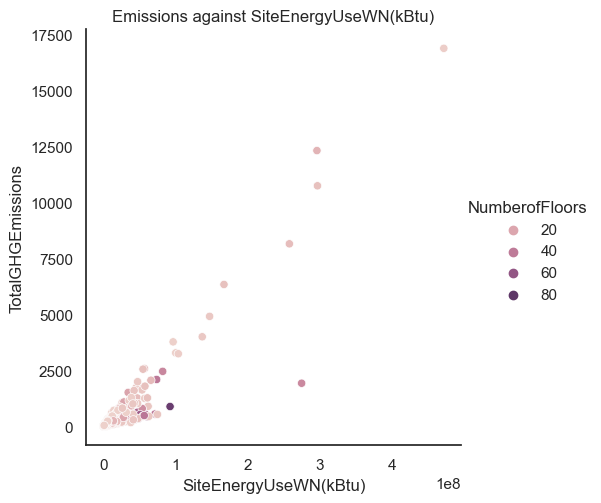

In [49]:
sns.relplot(data=df,x="SiteEnergyUseWN(kBtu)",y="TotalGHGEmissions",hue="NumberofFloors").set(title = "Emissions against SiteEnergyUseWN(kBtu)")

[Text(0.5, 1.0, 'Emissions against NumberofFloors')]

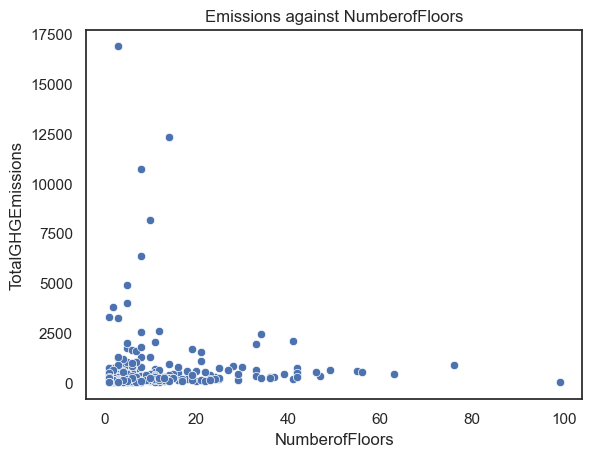

In [50]:
sns.scatterplot(data=df, x="NumberofFloors", y="TotalGHGEmissions").set(title = "Emissions against NumberofFloors")

[Text(0.5, 1.0, 'Emissions against NumberofBuildings')]

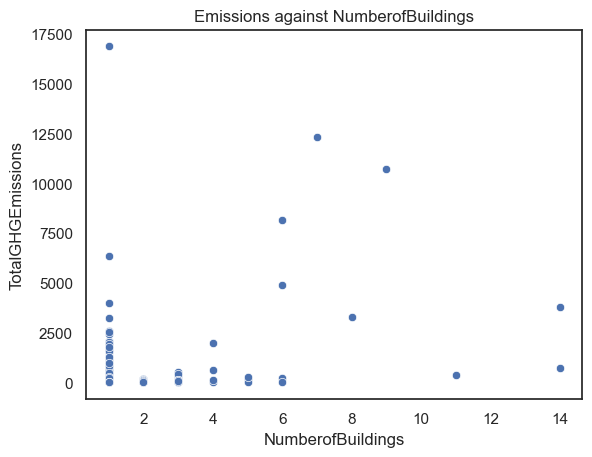

In [51]:
sns.scatterplot(data=df, x="NumberofBuildings", y="TotalGHGEmissions").set(title = "Emissions against NumberofBuildings")

[Text(0.5, 1.0, 'Emissions against ENERGYSTARScore')]

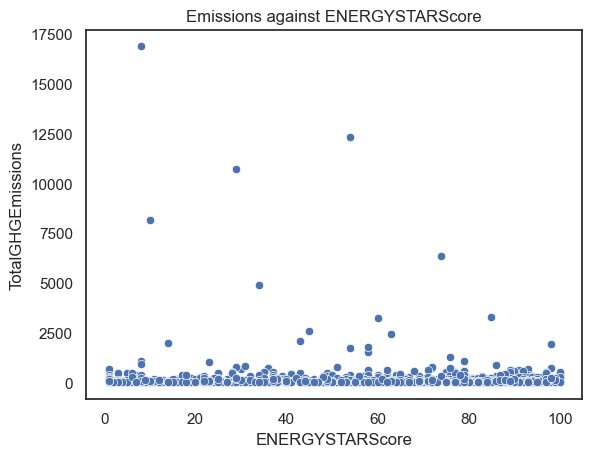

In [52]:
sns.scatterplot(data=dfclean, x="ENERGYSTARScore", y="TotalGHGEmissions").set(title = "Emissions against ENERGYSTARScore")

[Text(0.5, 1.0, 'SiteEnergyUseWN against ENERGYSTARScore')]

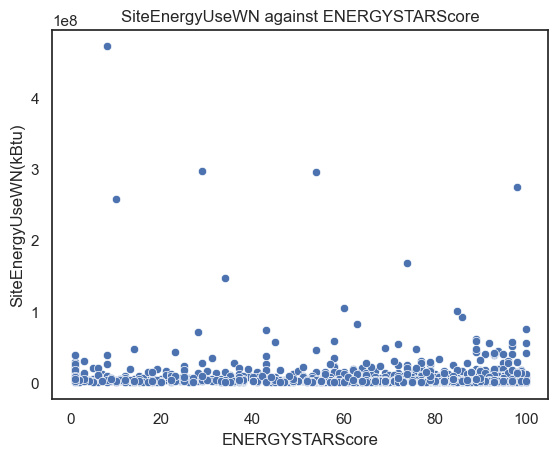

In [53]:
sns.scatterplot(data=dfclean, x="ENERGYSTARScore", y="SiteEnergyUseWN(kBtu)").set(title = "SiteEnergyUseWN against ENERGYSTARScore")

Principal composant analysis (PCA) :

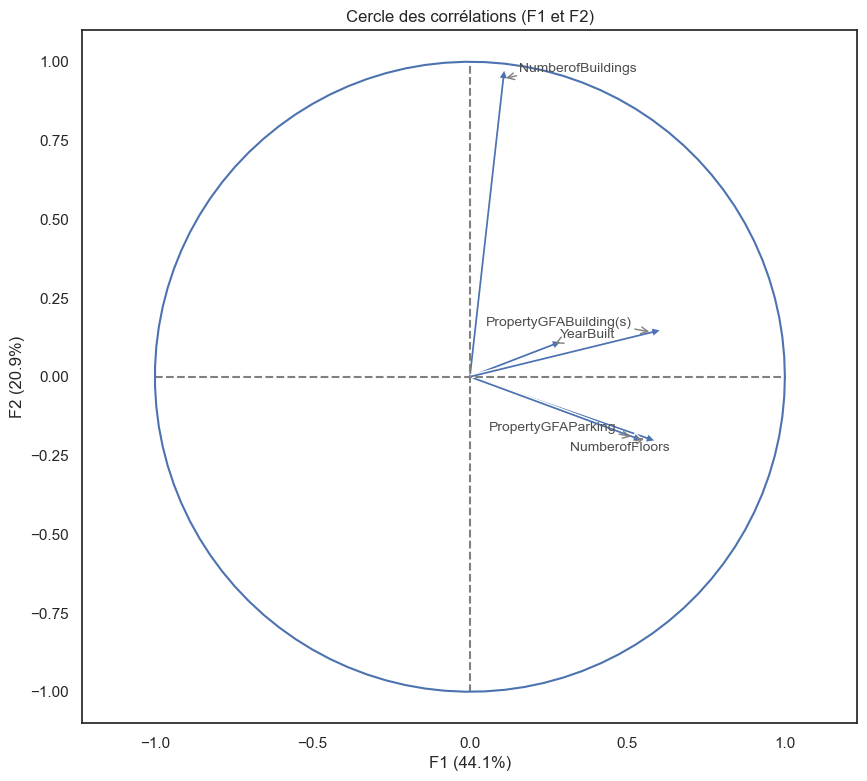

In [54]:
#Normalisation
colsubset = ["YearBuilt","NumberofBuildings","NumberofFloors","PropertyGFAParking","PropertyGFABuilding(s)"]
object = StandardScaler()
df_normalized = object.fit_transform(df[colsubset].select_dtypes(include = np.number))

#PCA
from sklearn.decomposition import PCA
n_components = df[colsubset].select_dtypes(include = np.number).shape[1]
pca = PCA(n_components=n_components)
reduced = pca.fit(df_normalized)
from adjustText import adjust_text

def correlation_graph(pca, 
                      x_y, 
                      features) : 
    """Affiche le graphe des correlations

    Positional arguments : 
    -----------------------------------
    pca : sklearn.decomposition.PCA : notre objet PCA qui a été fit
    x_y : list ou tuple : le couple x,y des plans à afficher, exemple [0,1] pour F1, F2
    features : list ou tuple : la liste des features (ie des dimensions) à représenter
    """

    # Extrait x et y 
    x,y=x_y

    # Taille de l'image (en inches)
    fig, ax = plt.subplots(figsize=(10, 9))

    TEXTS = []
    GREY50 = "#7F7F7F"
    GREY30 = "#4d4d4d"
    
    # Pour chaque composante : 
    for i in range(0, pca.components_.shape[1]):

        # Les flèches
        ax.arrow(0,0, 
                pca.components_[x, i],  
                pca.components_[y, i],  
                head_width=0.03,
                head_length=0.03, 
                width=0.01, )
    
        # Les labels
        TEXTS.append(ax.text(pca.components_[x, i], pca.components_[y, i], features[i], color=GREY30, fontsize=10))
    
    adjust_text(
    TEXTS, 
    expand_points=(2, 2),
    arrowprops=dict(
        arrowstyle="->", 
        color=GREY50, 
        lw=1
    ),
    ax=fig.axes[0]
)
    
    # Affichage des lignes horizontales et verticales
    plt.plot([-1, 1], [0, 0], color='grey', ls='--')
    plt.plot([0, 0], [-1, 1], color='grey', ls='--')

    # Nom des axes, avec le pourcentage d'inertie expliqué
    plt.xlabel('F{} ({}%)'.format(x+1, round(100*pca.explained_variance_ratio_[x],1)))
    plt.ylabel('F{} ({}%)'.format(y+1, round(100*pca.explained_variance_ratio_[y],1)))

    plt.title("Cercle des corrélations (F{} et F{})".format(x+1, y+1))

    # Le cercle 
    an = np.linspace(0, 2 * np.pi, 100)
    plt.plot(np.cos(an), np.sin(an))  # Add a unit circle for scale

    # Axes et display
    plt.axis('equal')
    plt.show(block=False)


correlation_graph(pca,(0,1),colsubset)

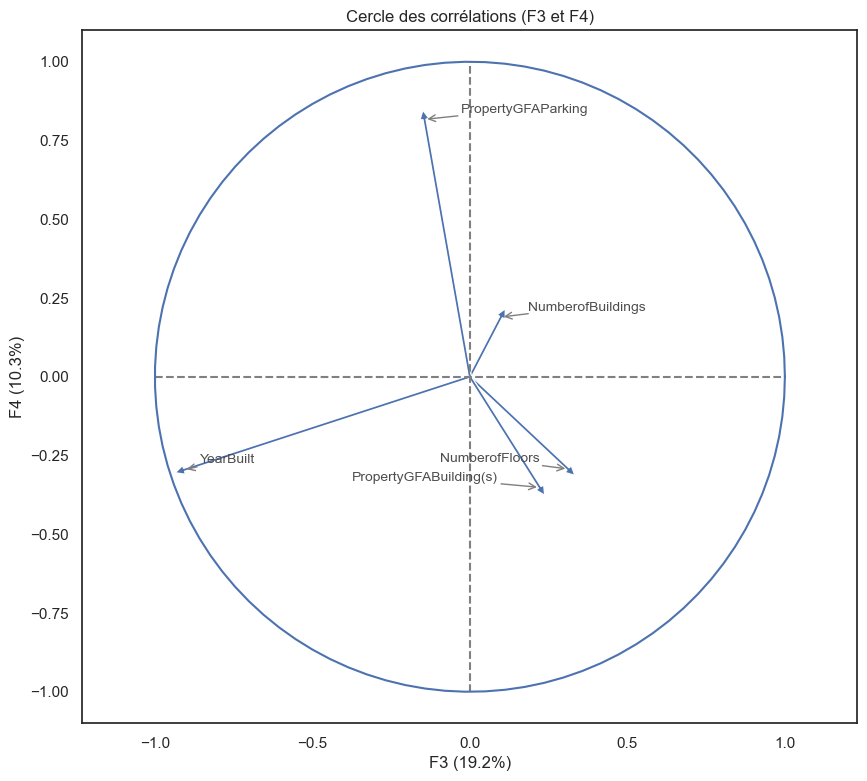

In [55]:
correlation_graph(pca,(2,3),colsubset)

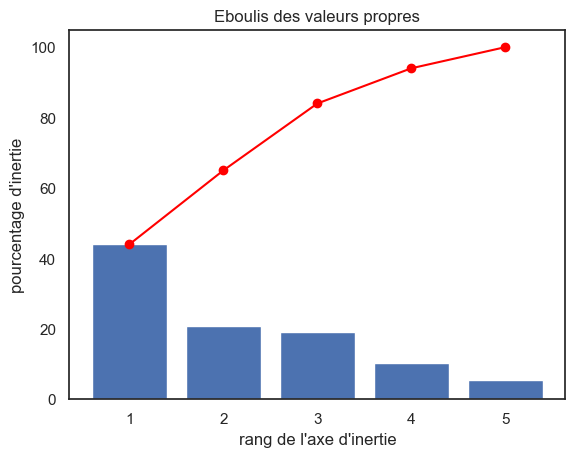

In [56]:
scree = (pca.explained_variance_ratio_*100).round(2)
scree_cum = scree.cumsum().round()
x_list = range(1, n_components+1)
plt.bar(x_list, scree)
plt.plot(x_list, scree_cum,c="red",marker='o')
plt.xlabel("rang de l'axe d'inertie")
plt.ylabel("pourcentage d'inertie")
plt.title("Eboulis des valeurs propres")
plt.show(block=False)

Text(0.5, 1.0, 'Heatmap des composantes')

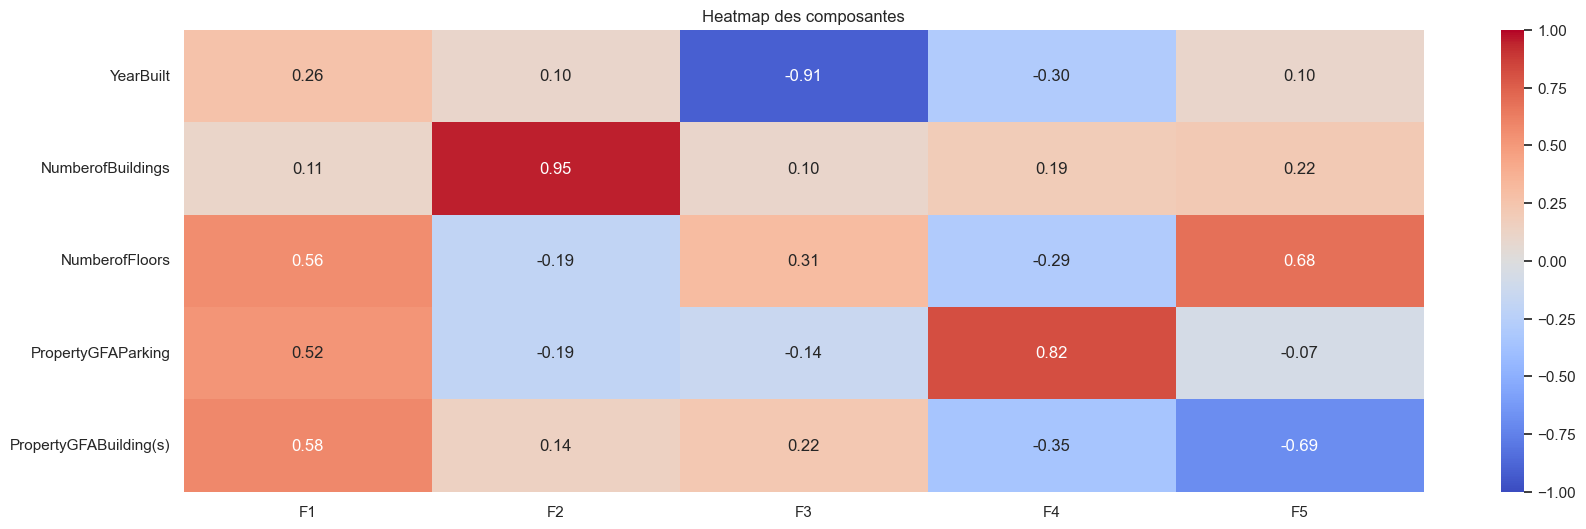

In [57]:
features = colsubset
pcs = pca.components_
pcs = pd.DataFrame(pcs)
pcs.columns = features
pcs.index = [f"F{i}" for i in x_list]
fig, ax = plt.subplots(figsize=(20, 6))
sns.heatmap(pcs.T, vmin=-1, vmax=1, annot=True, cmap="coolwarm", fmt="0.2f")
plt.title("Heatmap des composantes")

In [58]:
#Projection of data
X_proj = pca.transform(df_normalized)
x_list = range(1, n_components+1)
dff= pd.DataFrame(data = X_proj,columns = [f"F{i}" for i in x_list]) 
dfext = resdf.join(dff)

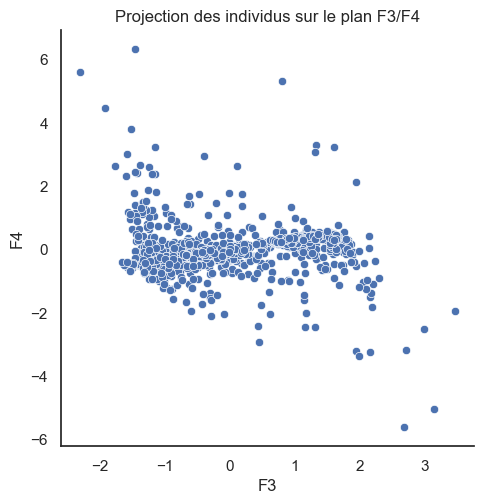

In [59]:
sns.relplot(data=dfext,x="F3",y="F4").set(title = "Projection des individus sur le plan F3/F4")


Our target features have an uncommon shape, applying a log transformation to them make them ressemble a normal distribution is better for our future model. 

[Text(0.5, 1.0, 'Emissions ditribution')]

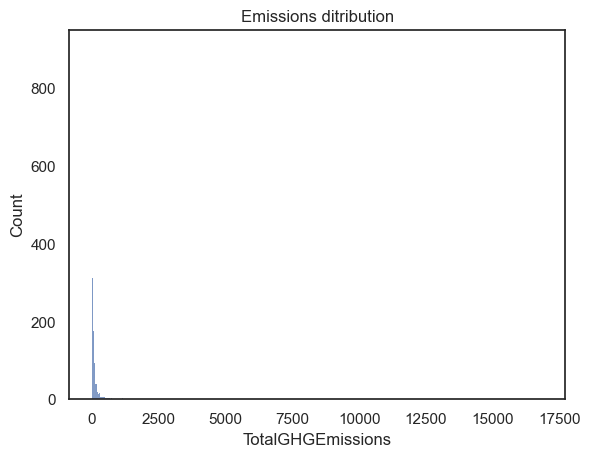

In [60]:
barplot = sns.histplot(data=rawdf,x="TotalGHGEmissions")
barplot.set(title='Emissions ditribution')

[Text(0.5, 1.0, 'Emissions ditribution log scale')]

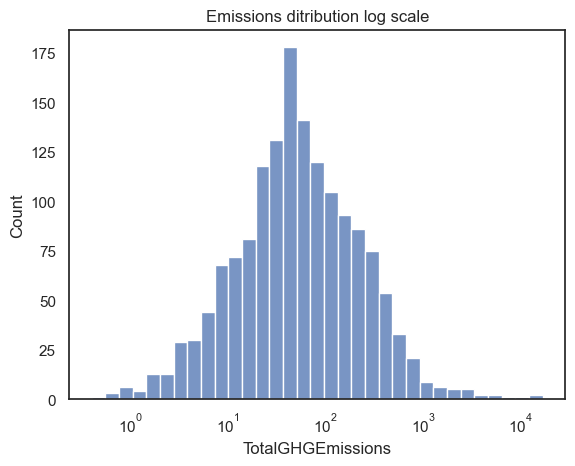

In [61]:
barplot = sns.histplot(data=df,x="TotalGHGEmissions",log_scale = True)
barplot.set(title='Emissions ditribution log scale')

[Text(0.5, 1.0, 'Energy use ditribution')]

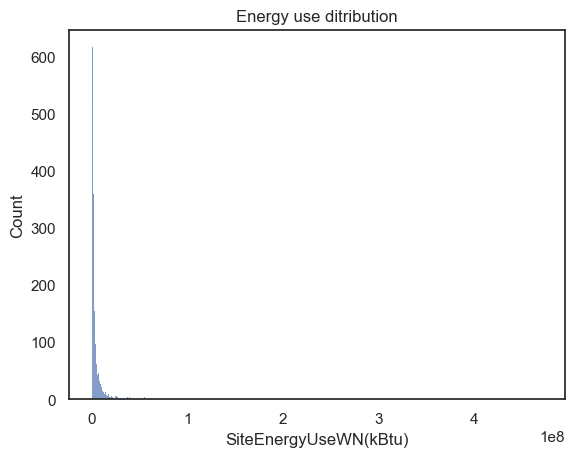

In [62]:
barplot = sns.histplot(data=rawdf,x="SiteEnergyUseWN(kBtu)")
barplot.set(title='Energy use ditribution')

[Text(0.5, 1.0, 'Energy use ditribution log scale')]

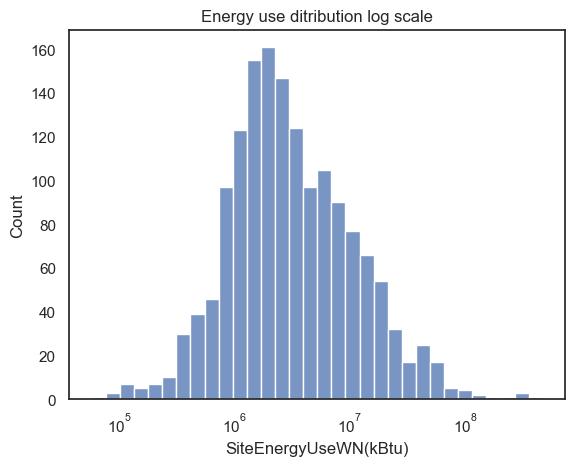

In [63]:
barplot = sns.histplot(data=df,x="SiteEnergyUseWN(kBtu)",log_scale = True)
barplot.set(title='Energy use ditribution log scale')

In [64]:
#log transformation
df["TotalGHGEmissions"] = np.log(df["TotalGHGEmissions"])
df["SiteEnergyUseWN(kBtu)"] = np.log(df["SiteEnergyUseWN(kBtu)"])

We need to encode our categorical data (property use and location). We use a one hot encoder for both and refine the property use by weighting it with its gross floor area.

In [65]:
# creating instance of one-hot-encoder
ohe = OneHotEncoder(handle_unknown='ignore')
transformed = ohe.fit_transform(df[["Neighborhood"]])
#adding encoded columns to dataframe
df[ohe.categories_[0]] = transformed.toarray()

#dropping original column
df.drop(columns=["Neighborhood"])

,OSEBuildingID,YearBuilt,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),ENERGYSTARScore,SiteEnergyUseWN(kBtu),TotalGHGEmissions,BALLARD,CENTRAL,DELRIDGE,DELRIDGE NEIGHBORHOODS,DOWNTOWN,EAST,GREATER DUWAMISH,LAKE UNION,MAGNOLIA / QUEEN ANNE,NORTH,NORTHEAST,NORTHWEST,SOUTHEAST,SOUTHWEST
0,1,1927,HOTEL,88434.0,UNKNOWN,0.0,UNKNOWN,0.0,1.0,12,88434,0,88434,1.0,1.0,1.0,60.0,15.824652,5.521381,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,1996,HOTEL,83880.0,PARKING,15064.0,RESTAURANT,4622.0,1.0,11,103566,15064,88502,0.0,1.0,1.0,61.0,15.974742,5.689886,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,1969,HOTEL,756493.0,UNKNOWN,0.0,UNKNOWN,0.0,1.0,41,956110,196718,759392,1.0,1.0,1.0,43.0,18.118725,7.644575,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,5,1926,HOTEL,61320.0,UNKNOWN,0.0,UNKNOWN,0.0,1.0,10,61320,0,61320,1.0,1.0,1.0,56.0,15.753792,5.657494,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,8,1980,HOTEL,123445.0,PARKING,68009.0,SWIMMING POOL,0.0,1.0,18,175580,62000,113580,0.0,1.0,1.0,75.0,16.500395,6.224578,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3371,50222,1990,OFFICE,12294.0,UNKNOWN,0.0,UNKNOWN,0.0,1.0,1,12294,0,12294,0.0,1.0,1.0,46.0,13.756825,3.041661,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3372,50223,2004,OTHER - RECREATION,16000.0,UNKNOWN,0.0,UNKNOWN,0.0,1.0,1,16000,0,16000,0.0,1.0,1.0,NaN,13.867824,3.471034,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3373,50224,1974,OTHER - RECREATION,7583.0,FITNESS CENTER/HEALTH CLUB/GYM,5574.0,SWIMMING POOL,0.0,1.0,1,13157,0,13157,0.0,1.0,1.0,NaN,15.616191,5.409590,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3374,50225,1989,OTHER - RECREATION,6601.0,FITNESS CENTER/HEALTH CLUB/GYM,6501.0,PRE-SCHOOL/DAYCARE,484.0,1.0,1,14101,0,14101,0.0,1.0,1.0,NaN,13.570685,3.096030,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [66]:
def PropertyUseEncoder(df,Type,TypeGFA,TotalGFA):
    # creating instance of one-hot-encoder
    ohe = OneHotEncoder(handle_unknown='ignore')
    transformed = ohe.fit_transform(df[[Type]])



    #adding encoded columns to dummy dataframe
    dfdummy = pd.DataFrame(index=df.index)
    dfdummy[ohe.categories_[0]] = transformed.toarray()
    ratioGFA = df[TypeGFA]/df[TotalGFA]


    
    return dfdummy.mul(ratioGFA, axis=0)

In [67]:
df1 = PropertyUseEncoder(df,"LargestPropertyUseType","LargestPropertyUseTypeGFA","PropertyGFATotal")
df2 = PropertyUseEncoder(df,"SecondLargestPropertyUseType","SecondLargestPropertyUseTypeGFA","PropertyGFATotal")
df3 = PropertyUseEncoder(df,"ThirdLargestPropertyUseType","ThirdLargestPropertyUseTypeGFA","PropertyGFATotal")

In [68]:
df1 = df1.add(df2,fill_value=0.)
df1 = df1.add(df3,fill_value=0.)

In [69]:
df = df.drop(columns = ["PropertyGFATotal","Neighborhood","LargestPropertyUseType","SecondLargestPropertyUseType","SecondLargestPropertyUseTypeGFA","ThirdLargestPropertyUseType","ThirdLargestPropertyUseTypeGFA"])

In [70]:
df = pd.concat([df, df1], axis=1)
df = df.set_index(keys="OSEBuildingID")

Here we normalise our numerical data :

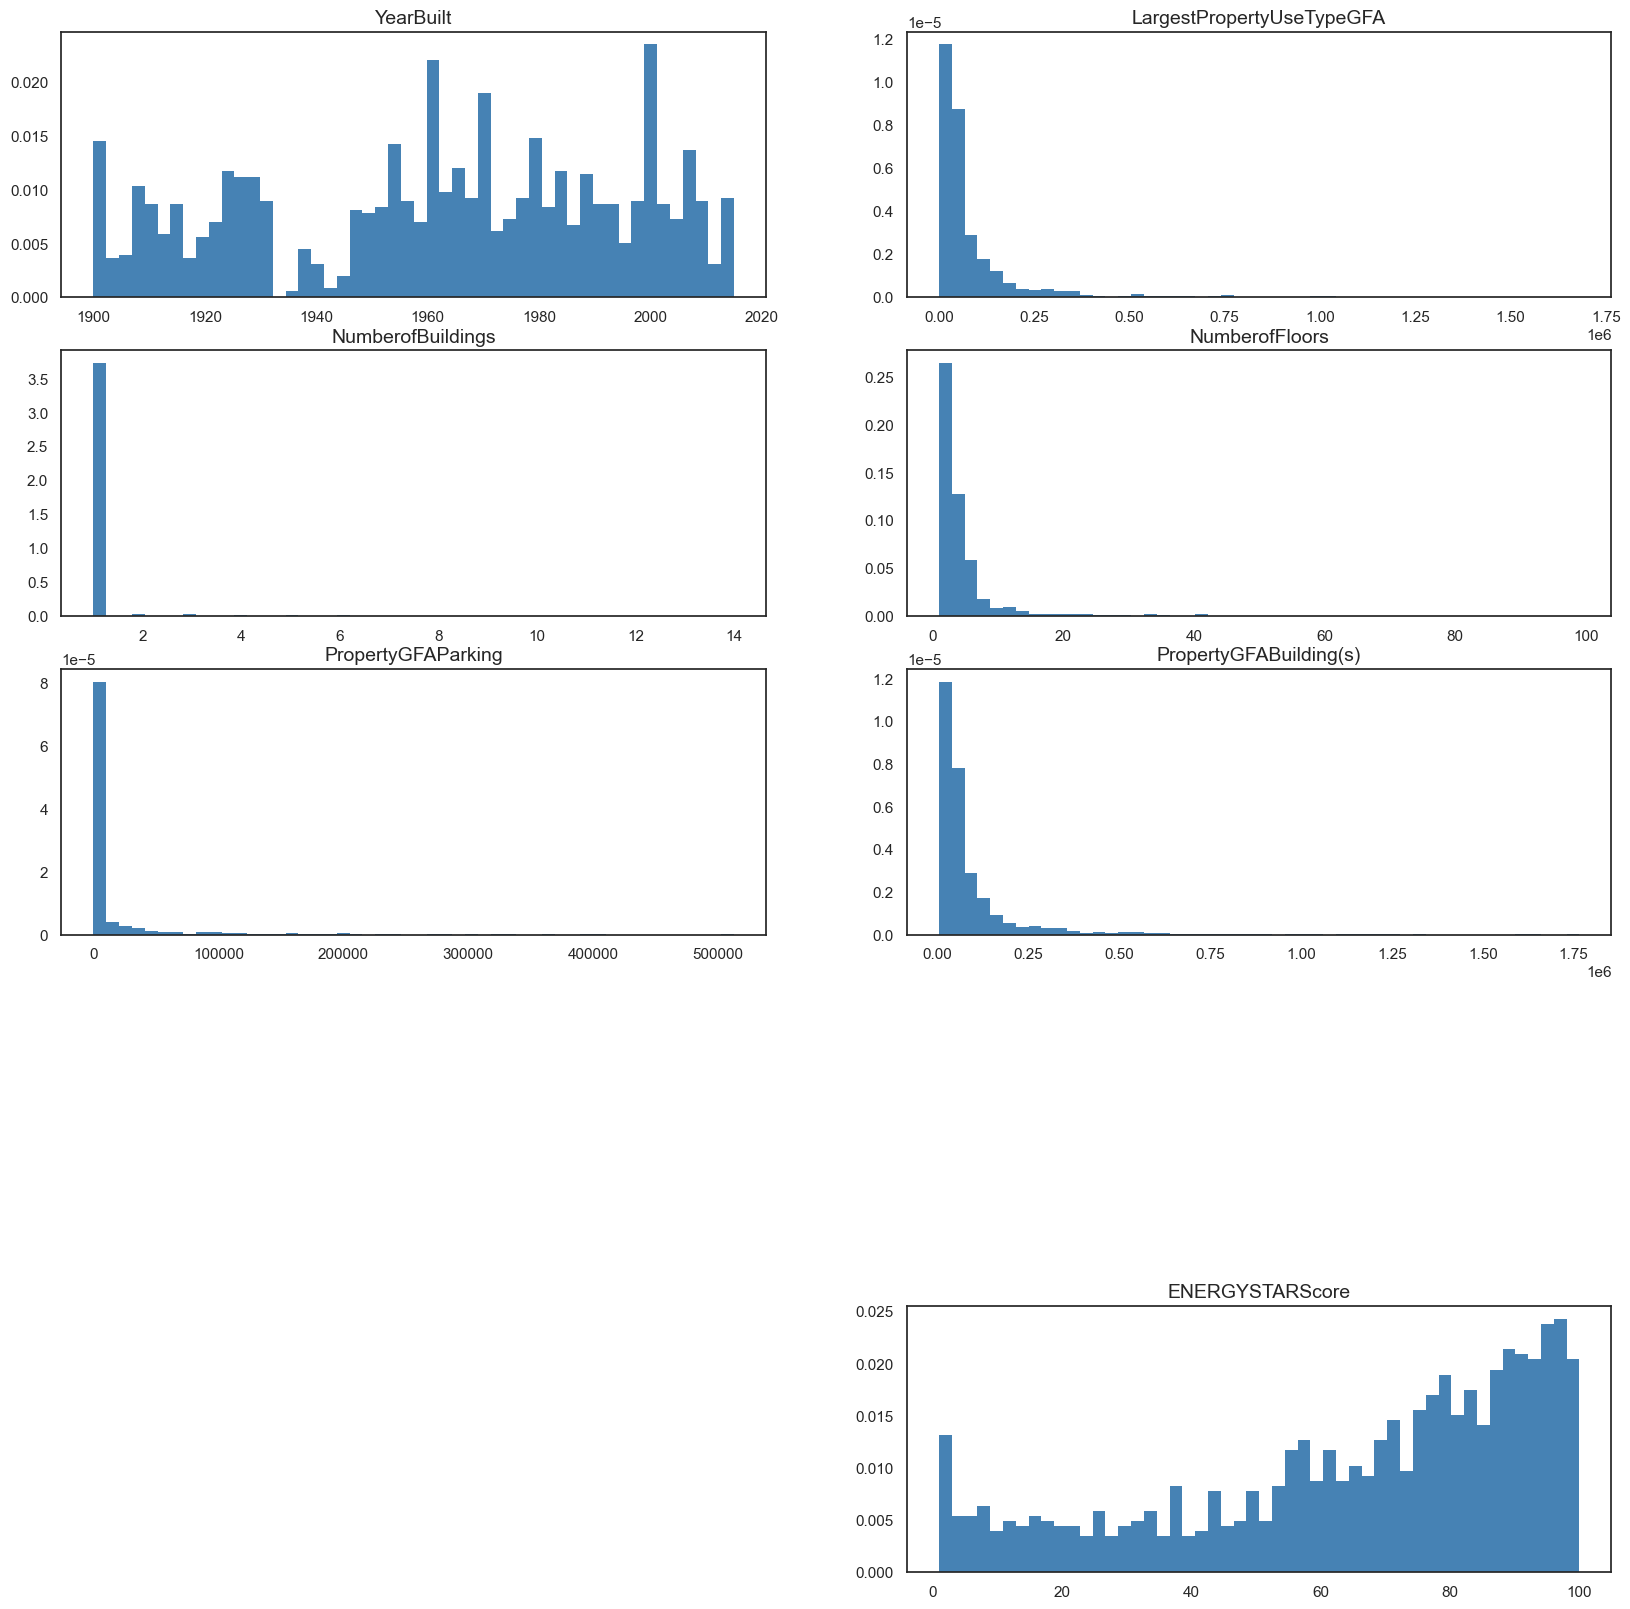

In [75]:
#Normalisation

scaler = StandardScaler()
colsubset = ["YearBuilt","NumberofBuildings","LargestPropertyUseTypeGFA","NumberofFloors","PropertyGFAParking","PropertyGFABuilding(s)","ENERGYSTARScore"]

fig = plt.figure(figsize=(20, 20))
for feat_idx in df[colsubset].columns:
    ax = fig.add_subplot(5,2, (df.columns.get_loc(feat_idx)+1))
    h = ax.hist(df[feat_idx], bins=50, color = 'steelblue', density=True, edgecolor='none')
    ax.set_title(feat_idx, fontsize=14)

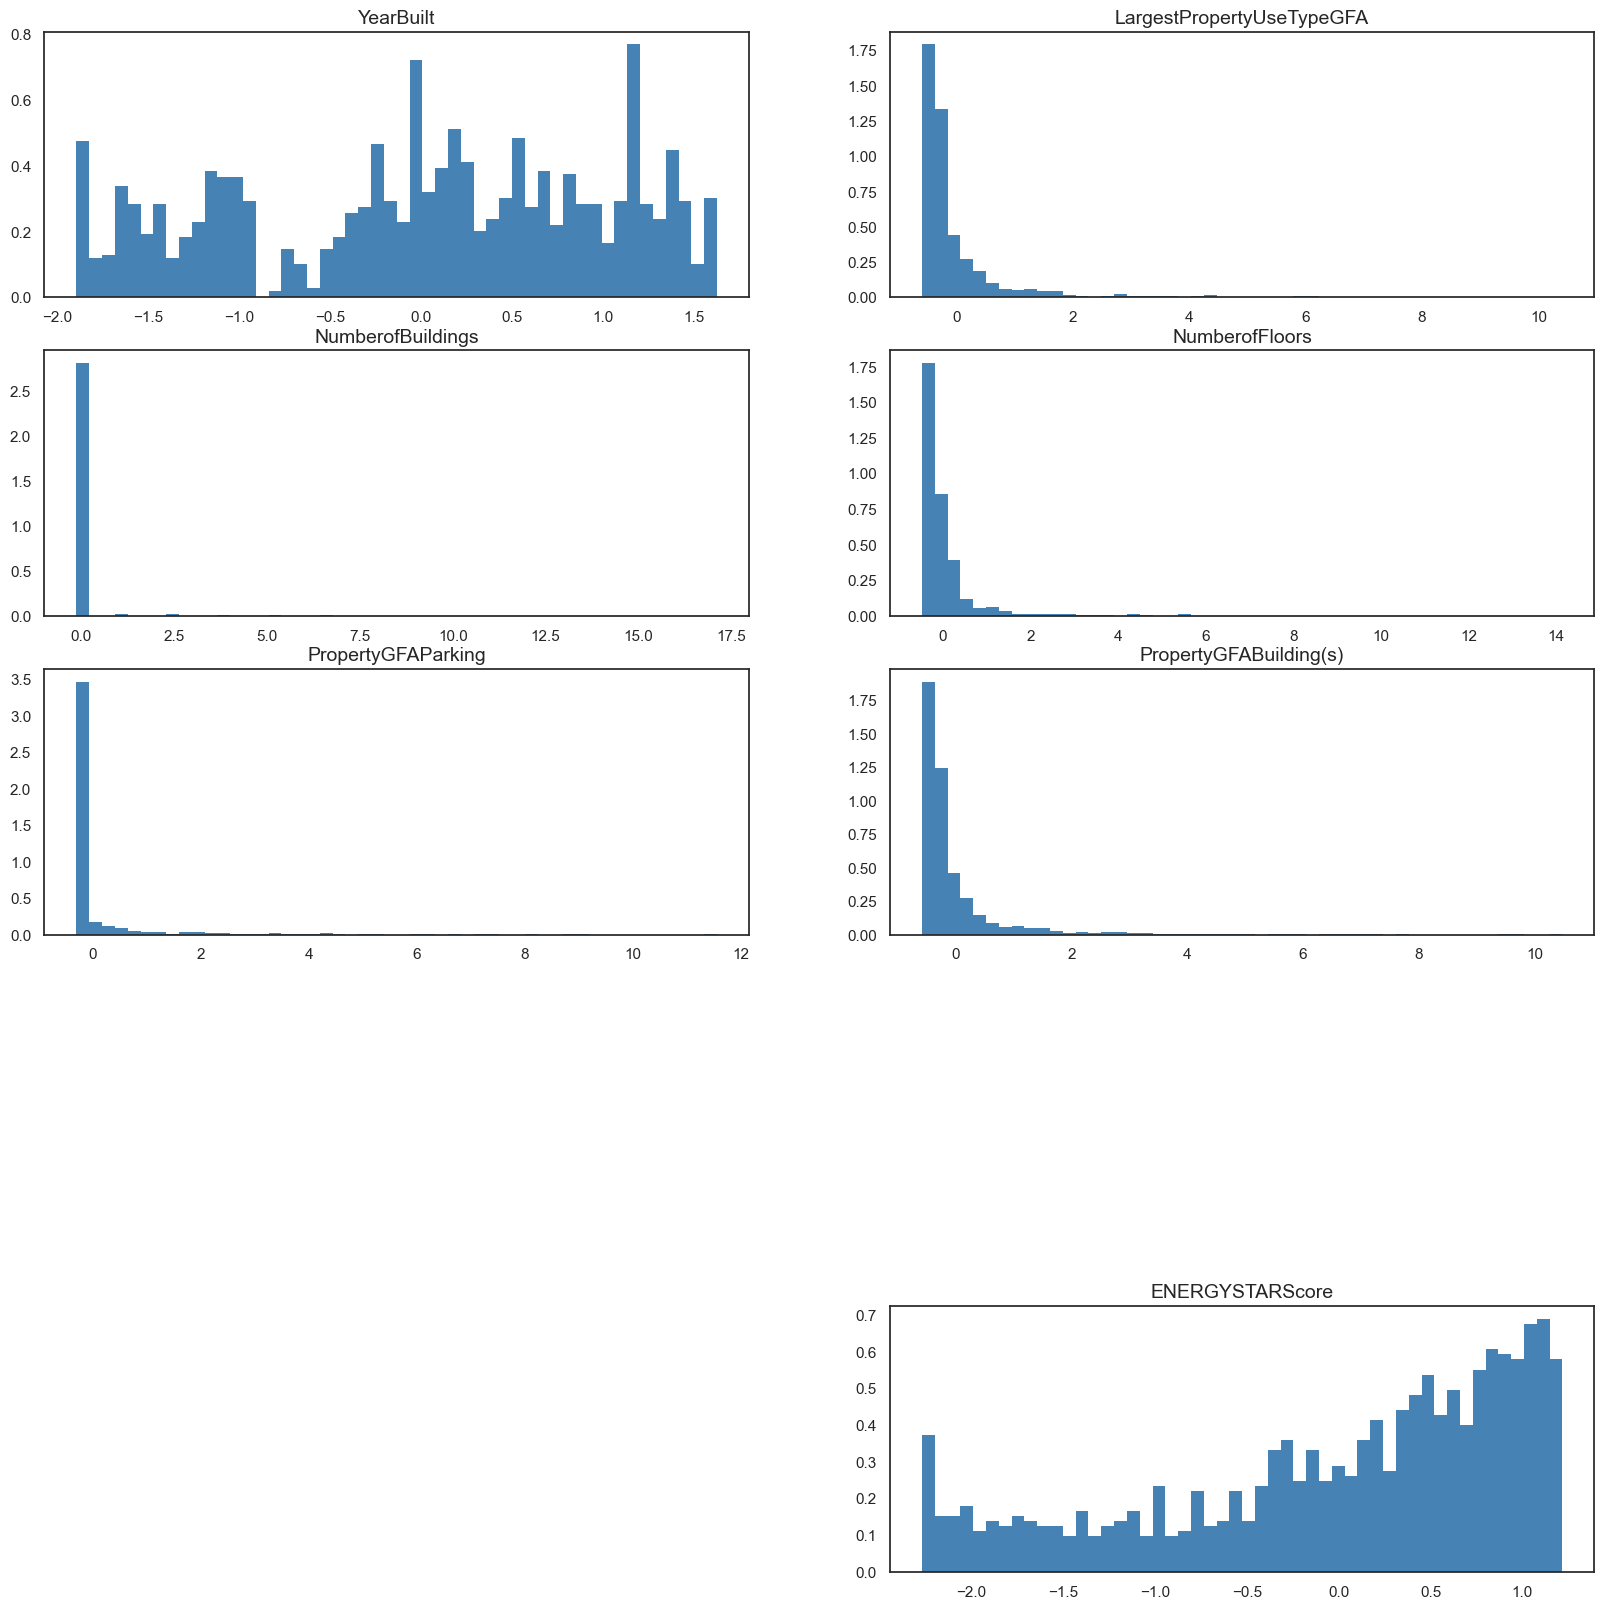

In [76]:


df[colsubset] = scaler.fit_transform(df[colsubset].select_dtypes(include = np.number))

fig = plt.figure(figsize=(20, 20))
for feat_idx in df[colsubset].columns:
    ax = fig.add_subplot(5,2, (df.columns.get_loc(feat_idx)+1))
    h = ax.hist(df[feat_idx], bins=50, color = 'steelblue', density=True, edgecolor='none')
    ax.set_title(feat_idx, fontsize=14)


In [77]:
df

,YearBuilt,LargestPropertyUseTypeGFA,NumberofBuildings,NumberofFloors,PropertyGFAParking,PropertyGFABuilding(s),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),ENERGYSTARScore,SiteEnergyUseWN(kBtu),TotalGHGEmissions,BALLARD,CENTRAL,DELRIDGE,DELRIDGE NEIGHBORHOODS,DOWNTOWN,EAST,GREATER DUWAMISH,LAKE UNION,MAGNOLIA / QUEEN ANNE,NORTH,NORTHEAST,NORTHWEST,SOUTHEAST,SOUTHWEST,ADULT EDUCATION,AUTOMOBILE DEALERSHIP,BANK BRANCH,BAR/NIGHTCLUB,COLLEGE/UNIVERSITY,CONVENIENCE STORE WITHOUT GAS STATION,COURTHOUSE,DATA CENTER,DISTRIBUTION CENTER,ENCLOSED MALL,FAST FOOD RESTAURANT,FINANCIAL OFFICE,FIRE STATION,FITNESS CENTER/HEALTH CLUB/GYM,FOOD SALES,FOOD SERVICE,HOSPITAL (GENERAL MEDICAL & SURGICAL),HOTEL,K-12 SCHOOL,LABORATORY,LIBRARY,LIFESTYLE CENTER,MANUFACTURING/INDUSTRIAL PLANT,MEDICAL OFFICE,MOVIE THEATER,MULTIFAMILY HOUSING,MUSEUM,NON-REFRIGERATED WAREHOUSE,OFFICE,OTHER,OTHER - EDUCATION,OTHER - ENTERTAINMENT/PUBLIC ASSEMBLY,OTHER - LODGING/RESIDENTIAL,OTHER - MALL,OTHER - PUBLIC SERVICES,OTHER - RECREATION,OTHER - RESTAURANT/BAR,OTHER - SERVICES,OTHER - TECHNOLOGY/SCIENCE,OTHER - UTILITY,OTHER/SPECIALTY HOSPITAL,PARKING,PERFORMING ARTS,"PERSONAL SERVICES (HEALTH/BEAUTY, DRY CLEANING, ETC)",POLICE STATION,PRE-SCHOOL/DAYCARE,PRISON/INCARCERATION,REFRIGERATED WAREHOUSE,"REPAIR SERVICES (VEHICLE, SHOE, LOCKSMITH, ETC)",RESIDENCE HALL/DORMITORY,RESIDENTIAL CARE FACILITY,RESTAURANT,RETAIL STORE,SELF-STORAGE FACILITY,SENIOR CARE COMMUNITY,SOCIAL/MEETING HALL,STRIP MALL,SUPERMARKET/GROCERY STORE,SWIMMING POOL,UNKNOWN,URGENT CARE/CLINIC/OTHER OUTPATIENT,VOCATIONAL SCHOOL,WORSHIP FACILITY
OSEBuildingID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,-1.068622,-0.011294,-0.132516,1.165215,-0.307204,-0.050910,1.0,1.0,1.0,-0.191307,15.824652,5.521381,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.043143,-0.041096,-0.132516,1.016055,0.041745,-0.050483,0.0,1.0,1.0,-0.156074,15.974742,5.689886,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.809918,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.145453,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.044629,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.216801,4.360572,-0.132516,5.490849,4.249656,4.161830,1.0,1.0,1.0,-0.790264,18.118725,7.644575,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.791220,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,-1.099227,-0.188732,-0.132516,0.866895,-0.307204,-0.221151,1.0,1.0,1.0,-0.332238,15.753792,5.657494,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.553459,0.217822,-0.132516,2.060174,1.128991,0.106974,0.0,1.0,1.0,0.337184,16.500395,6.224578,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.703070,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.387339,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

We end going from 1668 to 1552 buildings.

Saving the final cleaned dataset :

In [78]:
df.to_csv(r'E:\DL\2016_Building_Energy_Benchmarking_cleaned.csv', encoding = 'utf8',sep=',')